In [31]:
#!pip install optuna
import pandas as pd
import pickle
import datetime
import re
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
import matplotlib.pyplot as pit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import optuna.integration.lightgbm as lgb_o
import lightgbm as lgb

# exports
def plot_calibration_curve(named_classifiers, X_test, y_test):
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="完全な補正")
    for name, clf in named_classifiers.items():
        prob_pos = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, prob_pos)
        brier = brier_score_loss(y_test, prob_pos)
        print("%s:" % name)
        print("\tAUC  : %1.3f" % auc)
        print("\tBrier: %1.3f" % (brier))
        print()

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test,
            prob_pos,
            n_bins=10,
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label="%s (%1.3f)" % (name, brier),
        )

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

    ax1.set_ylabel("正例の比率")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title("信頼性曲線")

    ax2.set_xlabel("予測値の平均")
    ax2.set_ylabel("サンプル数")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    
def build_data(base_name, new_name, result, vec):
    allrace = pd.read_pickle(base_name)

    df = allrace.query('((course == 2 | course == 1) and (grade > 1))')
    all_r = preprocessing(df)
    all_r['result'] = all_r['result'].map(lambda x: 1 if x < result else 0)
    
    all_r = all_r.fillna({
    '1走前騎手ID': 0,'1走前減量騎手か': 0,'1走前ブリンカー着用': 0,'1走前出遅れ': 0,'1走前脚質': 0,'1走前不利': 0, '1走前距離': 0, '1走前場所': 0,'1走前コース': 0,'1走前出走クラス': 0,'1走前1着脚質': 0,
    '2走前騎手ID': 0,'2走前減量騎手か': 0,'2走前ブリンカー着用': 0,'2走前出遅れ': 0,'2走前脚質': 0,'2走前不利': 0, '2走前距離': 0, '2走前場所': 0,'2走前コース': 0,'2走前出走クラス': 0,'2走前1着脚質': 0,
    '3走前騎手ID': 0,'3走前減量騎手か': 0,'3走前ブリンカー着用': 0,'3走前出遅れ': 0,'3走前脚質': 0,'3走前不利': 0, '3走前距離': 0, '3走前場所': 0,'3走前コース': 0,'3走前出走クラス': 0,'3走前1着脚質': 0,
    '4走前騎手ID': 0,'4走前減量騎手か': 0,'4走前ブリンカー着用': 0,'4走前出遅れ': 0,'4走前脚質': 0,'4走前不利': 0, '4走前距離': 0, '4走前場所': 0,'4走前コース': 0,'4走前出走クラス': 0,'4走前1着脚質': 0,
    '5走前騎手ID': 0,'5走前減量騎手か': 0,'5走前ブリンカー着用': 0,'5走前出遅れ': 0,'5走前脚質': 0,'5走前不利': 0, '5走前距離': 0, '5走前場所': 0,'5走前コース': 0,'5走前出走クラス': 0,'5走前1着脚質': 0,
    })
    categorical = process_categorical(all_r, [
        'producer', 'owner', 'training_course',  'course',
        'jockey_id', 'gender', 'trainer_id', 'weight',
        '天候', '馬場状態', 'grade', 'age', 'place_id',
        'color_id', 'stallion_id', 'affiliation_id',
        '1走前騎手ID','1走前減量騎手か','1走前ブリンカー着用','1走前出遅れ','1走前脚質','1走前不利','1走前場所', '1走前距離', '1走前コース','1走前出走クラス','1走前1着脚質',
        '2走前騎手ID','2走前減量騎手か','2走前ブリンカー着用','2走前出遅れ','2走前脚質','2走前不利','2走前場所', '2走前距離', '2走前コース','2走前出走クラス','2走前1着脚質',
        '3走前騎手ID','3走前減量騎手か','3走前ブリンカー着用','3走前出遅れ','3走前脚質','3走前不利','3走前場所', '3走前距離', '3走前コース','3走前出走クラス','3走前1着脚質',
        '4走前騎手ID','4走前減量騎手か','4走前ブリンカー着用','4走前出遅れ','4走前脚質','4走前不利','4走前場所', '4走前距離', '4走前コース','4走前出走クラス','4走前1着脚質',
        '5走前騎手ID','5走前減量騎手か','5走前ブリンカー着用','5走前出遅れ','5走前脚質','5走前不利','5走前場所', '5走前距離', '5走前コース','5走前出走クラス','5走前1着脚質',
    ])

    categorical = categorical.reset_index()
    categorical = categorical.merge(vec, on='horse_id')
    categorical = categorical.set_index('race_id')

    train1, valid1 = split_data(categorical)
    valid1, test2 = train_valid_split_data(valid1)

    target = pd.read_pickle('./pickle_new/new_race_20221127.pickle')
    target = target.query('((course == 2 | course == 1) and (grade > 1))')
    target = preprocessing(target)
    target['result'] = target['result'].map(lambda x: 1 if x < result else 0)
    
    target = target.fillna({
    '1走前騎手ID': 0,'1走前減量騎手か': 0,'1走前ブリンカー着用': 0,'1走前出遅れ': 0,'1走前脚質': 0,'1走前不利': 0, '1走前距離': 0, '1走前場所': 0,'1走前コース': 0,'1走前出走クラス': 0,'1走前1着脚質': 0,
    '2走前騎手ID': 0,'2走前減量騎手か': 0,'2走前ブリンカー着用': 0,'2走前出遅れ': 0,'2走前脚質': 0,'2走前不利': 0, '2走前距離': 0, '2走前場所': 0,'2走前コース': 0,'2走前出走クラス': 0,'2走前1着脚質': 0,
    '3走前騎手ID': 0,'3走前減量騎手か': 0,'3走前ブリンカー着用': 0,'3走前出遅れ': 0,'3走前脚質': 0,'3走前不利': 0, '3走前距離': 0, '3走前場所': 0,'3走前コース': 0,'3走前出走クラス': 0,'3走前1着脚質': 0,
    '4走前騎手ID': 0,'4走前減量騎手か': 0,'4走前ブリンカー着用': 0,'4走前出遅れ': 0,'4走前脚質': 0,'4走前不利': 0, '4走前距離': 0, '4走前場所': 0,'4走前コース': 0,'4走前出走クラス': 0,'4走前1着脚質': 0,
    '5走前騎手ID': 0,'5走前減量騎手か': 0,'5走前ブリンカー着用': 0,'5走前出遅れ': 0,'5走前脚質': 0,'5走前不利': 0, '5走前距離': 0, '5走前場所': 0,'5走前コース': 0,'5走前出走クラス': 0,'5走前1着脚質': 0,
    })
    test1 = process_categorical(target,  [
        'producer', 'owner', 'training_course',  'course',
        'jockey_id', 'gender', 'trainer_id', 'weight',
        '天候', '馬場状態', 'grade', 'age', 'place_id',
        'color_id', 'stallion_id', 'affiliation_id', 'distance',
        '1走前騎手ID','1走前減量騎手か','1走前ブリンカー着用','1走前出遅れ','1走前脚質','1走前不利','1走前場所', '1走前距離', '1走前コース','1走前出走クラス','1走前1着脚質',
        '2走前騎手ID','2走前減量騎手か','2走前ブリンカー着用','2走前出遅れ','2走前脚質','2走前不利','2走前場所', '2走前距離', '2走前コース','2走前出走クラス','2走前1着脚質',
        '3走前騎手ID','3走前減量騎手か','3走前ブリンカー着用','3走前出遅れ','3走前脚質','3走前不利','3走前場所', '3走前距離', '3走前コース','3走前出走クラス','3走前1着脚質',
        '4走前騎手ID','4走前減量騎手か','4走前ブリンカー着用','4走前出遅れ','4走前脚質','4走前不利','4走前場所', '4走前距離', '4走前コース','4走前出走クラス','4走前1着脚質',
        '5走前騎手ID','5走前減量騎手か','5走前ブリンカー着用','5走前出遅れ','5走前脚質','5走前不利','5走前場所', '5走前距離', '5走前コース','5走前出走クラス','5走前1着脚質',
    ])

    test1 = test1.reset_index()
    test1 = test1.merge(vec, on='horse_id')
    test1 = test1.set_index('race_id')

    X_train1 = train1.drop(['id', 'index', 'date', 'result',  'time_popular', 'time_odds', 'odds', 'popular', 'horse_id', 'owner', 'producer', '気温', '風速'], axis=1)
    y_train1 = train1['result']
    X_valid1 = valid1.drop(['date', 'index', 'result', 'popular',  'time_popular', 'horse_id', 'owner', 'producer', '気温', '風速'], axis=1)
    y_valid1 = valid1['result']
    X_test2 = test2.drop(['date', 'index', 'result', 'popular',  'time_popular', 'horse_id', 'owner', 'producer', '気温', '風速'], axis=1)
    y_test2 = test2['result']
    X_test1 = test1.drop(['date', 'result', 'popular', 'popular',  'time_popular', 'horse_id', 'owner', 'producer', '気温', '風速'], axis=1)
    y_test1 = test1['result']
    
    return {
        'X_train': X_train1,
        'y_train': y_train1,
        'X_valid': X_valid1,
        'y_valid': y_valid1,
        'X_test2': X_test2,
        'y_test2': y_test2,
        'X_test1': X_test1,
        'y_test1': y_test1,
    }

def preprocessing(results, kako=5):
    df = results.copy()
    df.drop(['rank', 'body_weight'], axis=1, inplace=True)
    df['date'] = df['date'].astype(str).map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    
    df = df.sort_values(by='date', ascending = False)
    df = df.set_index('race_id')
    return df

def split_data(df, test_size=0.3, place=None):
    sorted_ids = df.sort_values('date').index.unique()
    train_ids = sorted_ids[:round(len(sorted_ids) * (1-test_size))]
    test_ids = sorted_ids[round(len(sorted_ids) * (1-test_size)):]

    train = df.loc[train_ids]
    test = df.loc[test_ids]
    
    return train, test

def train_valid_split_data(df, test_size=0.3):
    sorted_ids = df.sort_values('date').index.unique()
    train_ids = sorted_ids[:round(len(sorted_ids) * (1-test_size))]
    test_ids = sorted_ids[round(len(sorted_ids) * (1-test_size)):]
    
    train = df.loc[train_ids]
    valid = df.loc[test_ids]
    
    return train, valid

def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))
    # df2 = pd.get_dummies(df2, sparse=True)
    df2 = pd.get_dummies(df2)
    for column in target_columns:
        df2[column] = df2[column].astype('category')
        
    return df2

def optuna_params(X_train, y_train, X_valid, y_valid):
    lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
    lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

    params = {
        'objective': 'binary',
        'random_state': 100
    }

    lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_train, lgb_valid), verbose_eval=100, early_stopping_rounds=10)
    
    return lgb_clf_o.params

def fit(params, X, y):
    lgb_clf = lgb.LGBMClassifier(**params)
    lgb_clf.fit(X.values, y.values)
    
    return lgb_clf

def tansho_return_rate(X, wr, expected=True):
    wr['expected'] = wr['win_ratio'] * wr['time_odds'] 
    wr['pred_rank'] = wr[['win_ratio']].groupby('race_id').rank(ascending=False)
    
    race_grade = pd.read_csv('./csv_new2/races.csv')
    race_grade = race_grade.set_index('race_id')
    race_grade[['grade']]

    bets = wr.merge(race_grade, on='race_id')

    weather = pd.read_csv('./csv_new2/weathers.csv')
    bets = bets.merge(weather[['race_id', 'place_id']], on='race_id')

    if expected:
        # 賭ける馬
        v_bt = bets[
        #     (bets['pred_rank'] == 1)
        #     &
            (bets['expected'] >= 1)
        ]
    else:
        v_bt = bets

    kaime = v_bt.merge(haitou[['1着馬番', '単勝']], on='race_id')
    
    print("点数：{} レース数:{} 対象レース率:{:.1%} 単勝的中率:{:.1%} 的中数:{} 賭金:{:,}円 単勝配当合計:{:,}円 単勝最高配当:{:,}円 単勝回収率:{:.1%}". format(
        len(kaime),\
        len(X.groupby('race_id')),\
        len(kaime.groupby('race_id')) / len(X.groupby('race_id')),\
        len(kaime[kaime['h_num'] == kaime['1着馬番']]) / (len(kaime)),\
        len(kaime[kaime['h_num'] == kaime['1着馬番']]),\
        len(kaime) * 100,\
        kaime[kaime['h_num'] == kaime['1着馬番']]['単勝'].sum(),\
        kaime[kaime['h_num'] == kaime['1着馬番']]['単勝'].max(),\
        (kaime[kaime['h_num'] == kaime['1着馬番']]['単勝'].sum() / (len(kaime) * 100))
    ))
    
    return kaime

def fukusho_return_rate(bt):
    h = bt.merge(haitou, on='race_id')

    money = 0
    f_c = 0
    for i in range(1, 5):
        s = str(i)
        f_c += len(h[h['h_num'] == h[s + '着馬番']]['複勝' + s])
        money += h[h['h_num'] == h[s + '着馬番']]['複勝' + s].sum()

    print("点数：{} 賭金:{:,}円 複勝的中率:{:.1%} 複勝的中数:{} 複勝配当合計:{:,}円 複勝回収率:{:.1%}". format(
        len(bt),\
        (len(bt) * 100),\
        f_c / len(bt),\
        f_c,\
        int(money),
        (money / (len(bt) * 100)),\
    ))
    
def umaren_return_rate(fmrt, haitou):
    uma_haito = fmrt.merge(haitou[['1着馬番', '2着馬番', '馬連', '馬単']], on='race_id')

    f_bt = uma_haito[
        (
            (uma_haito['h_num_x'] == uma_haito['1着馬番'])
            &
            (uma_haito['h_num_y'] == uma_haito['2着馬番'])      
        )
        |
        (
            (uma_haito['h_num_x'] == uma_haito['2着馬番'])
            &
            (uma_haito['h_num_y'] == uma_haito['1着馬番'])      
        )
    ]


    print("点数：{} 的中数:{} 的中率:{:.1%}". format(
        len(uma_haito),\
        len(f_bt),\
        len(f_bt) / len(uma_haito)
    ))
    
    print("馬連賭金:{:,}円 馬連配当合計:{:,}円 馬連最高配当:{:,}円 馬連回収率:{:.1%}". format(
        (len(uma_haito) * 100),\
        f_bt['馬連'].sum(),\
        f_bt['馬連'].max(),\
        (f_bt['馬連'].sum() / (len(uma_haito) * 100))
    ))
    
    print("馬単賭金:{:,}円 馬単配当合計:{:,}円 馬単最高配当:{:,}円 馬単回収率:{:.1%}". format(
        (len(uma_haito) * 200),\
        f_bt['馬単'].sum(),\
        f_bt['馬単'].max(),\
        (f_bt['馬単'].sum() / (len(uma_haito) * 200))
    ))
    
    return uma_haito
    
def sanrenkei(kaime, haitou):
    kaime = kaime.merge(haitou, on='race_id')
    f_b3 = kaime[
        ((kaime['h_num_x'] == kaime['1着馬番']) & (kaime['h_num_y'] == kaime['2着馬番']) & (kaime['h_num'] == kaime['3着馬番']))
        |
        ((kaime['h_num_x'] == kaime['1着馬番']) & (kaime['h_num_y'] == kaime['3着馬番']) & (kaime['h_num'] == kaime['2着馬番']))
        |
        ((kaime['h_num_x'] == kaime['2着馬番']) & (kaime['h_num_y'] == kaime['1着馬番']) & (kaime['h_num'] == kaime['3着馬番']))
        |
        ((kaime['h_num_x'] == kaime['2着馬番']) & (kaime['h_num_y'] == kaime['3着馬番']) & (kaime['h_num'] == kaime['1着馬番']))
        |
        ((kaime['h_num_x'] == kaime['3着馬番']) & (kaime['h_num_y'] == kaime['1着馬番']) & (kaime['h_num'] == kaime['2着馬番']))
        |
        ((kaime['h_num_x'] == kaime['3着馬番']) & (kaime['h_num_y'] == kaime['2着馬番']) & (kaime['h_num'] == kaime['1着馬番']))
    ]
    
    print("点数：{} 的中数:{} 的中率:{:.1%}". format(
        len(kaime),\
        len(f_b3),\
        len(f_b3) / len(kaime)
    ))

    print("3連複賭金:{:,}円 3連複配当合計:{:,}円 3連複最高配当:{:,}円 3連複回収率:{:.1%}". format(
        len(kaime) * 100,\
        f_b3['3連複'].sum(),\
        f_b3['3連複'].max(),\
         (f_b3['3連複'].sum() / (len(kaime) * 100))
    ))
    
    print("3連単賭金:{:,}円 3連単配当合計:{:,}円 3連単最高配当:{:,}円 3連単回収率:{:.1%}". format(
        len(kaime) * 600,\
        int(f_b3['3連単'].sum()),\
        int(f_b3['3連単'].max()),\
        (f_b3['3連単'].sum() / (len(kaime) * 600))
    ))
    
def wide_rate(kaime, haitou):
    s = kaime.reset_index()
    s = s.merge(haitou, on='race_id')
    s = s[['race_id', 'h_num_x', 'h_num_y', 'h_num']]

    a = s[['race_id', 'h_num_x', 'h_num_y']]

    b = s[['race_id', 'h_num_y', 'h_num']]
    b['h_num_x'] = b['h_num_y']
    b['h_num_y'] = b['h_num']

    c = s[['race_id', 'h_num_x', 'h_num']]
    c['h_num_y'] = c['h_num']

    w = pd.concat([
        a[['race_id', 'h_num_x', 'h_num_y']],
        b[['race_id', 'h_num_x', 'h_num_y']],
        c[['race_id', 'h_num_x', 'h_num_y']],
    ]).drop_duplicates()
    wide = pd.read_csv('./csv_new2/base/wide.csv')
    w = w.merge(wide, on='race_id')
    
    wide = 0
    wide_tekichu = 0

    for i in range(1, 8):
        sm = str(i)
        w_b3 = w[
            (
                ((w['h_num_x'] == w['wide' + sm + '_uma1']) | (w['h_num_x'] == w['wide' + sm + '_uma2']))
                &
                ((w['h_num_y'] == w['wide' + sm + '_uma1']) | (w['h_num_y'] == w['wide' + sm + '_uma2']))
            )
        ]
        wide = wide + w_b3['wide_' + sm].sum()
        wide_tekichu = wide_tekichu + len(w_b3)

    print("ワイド点数：{} ワイド賭金:{:,}円 ワイド配当合計:{:,}円 ワイド的中数:{} ワイド的中率:{:.1%} ワイド回収率:{:.1%}". format(
        len(w),\
        len(w) * 100,\
        int(wide),\
        wide_tekichu,\
        wide_tekichu / len(w),\
        (wide / (len(w) * 100))
    ))

class TimeModel:
    def __init__(self, model, base_data):
        self.model = model
        self.base_data = base_data
        
    def pred_time(self, X):
        pred_time = self.base_data.copy()[['id', 'popular']]
        actual_table = X.copy()[['id', 'h_num', 'place_id']]

        X = X.drop(['id'], axis=1)
        actual_table['pred_time'] = model.predict(X)

        actual_table = actual_table.reset_index()
        pred_time = pred_time.reset_index()
        actual = pred_time.merge(actual_table, left_index=True, right_index=True, how='right')
        actual.drop(['id_x', 'id_y', 'race_id_y'], axis=1, inplace=True)

        return actual
    
    def race_pred_time(self, X):
        actual = self.pred_time(X)
        groups = actual.groupby('race_id_x').groups
        column_list = ["h_num", 'pred_time', 'popular']

        new_df = pd.DataFrame()
        max_length = 0
        for group, indexes in groups.items():
            # 最後に並び替えをさせるのに最大作成された項目数を記録
            length = len(indexes)+1
            if length > max_length:
                max_length = length

            columns = list()
            values = list()
            columns += ['race_id', 'place_id']
            values += [actual.iloc[indexes]['race_id_x'].T.tolist()[0], actual.iloc[indexes]['place_id'].T.tolist()[0]]

            for target_column in column_list:
                columns += [f'{target_column}_{x}' for x in range(1, length)]
                sort_values = actual.iloc[indexes, :].sort_values(by='pred_time', ascending = False)
                values += sort_values[target_column].T.tolist()

            record_df = pd.DataFrame([values], columns=columns)
            new_df = pd.concat([new_df, record_df], axis=0)

        return new_df

class ModelEvaluator:
    def __init__(self, model, haitou_table, std = True):
        self.model = model
        self.haitou = haitou_table
        self.std = std
        self.pp = None
        
    def predict_proba(self, X, std=True):
#         proba = pd.Series(self.model.predict_proba(X)[:, 1], index=X.index)
        if self.pp is not None:
          return self.pp

        proba = pd.Series(self.model.predict_proba(X.drop(['id', 'odds', 'time_odds'], axis=1))[:, 1], index=X.index)
        if std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            proba = (proba - proba.min()) / (proba.max() - proba.min())
            
        self.pp = proba
        return proba
    
    def prefict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def proba(self, X):
        y_pred = self.predict_proba(X)
        return [p for p in y_pred]
    
    def win_ratio(self, X):
        sum1 = pd.DataFrame(self.predict_proba(X).groupby(level=0).sum())
        y_pred = self.predict_proba(X)

        return [(p / sum1.loc[i])[0] for i, p in y_pred.items()]
    
    def score(self, y_true, X):
        proba = self.predict_proba(X, True)
        n = lambda x: 0.0 if np.isnan(x) else x
        proba = proba.map(n)
        return roc_auc_score(y_true, proba)
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({'features': X.columns, 'importance': self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['h_num', 'odds', 'time_odds']]
        pred_table['pred'] = self.prefict(X, threshold)
        pred_table['win_ratio'] = self.win_ratio(X)
        pred_table['proba'] = self.proba(X)
        if bet_only:
            pred_table = pred_table[pred_table['pred'] == 1][['h_num', 'odds', 'time_odds', 'win_ratio', 'proba']]
            return pred_table
        else:
            return pred_table[['h_num', 'odds', 'time_odds', 'win_ratio', 'proba']]
        
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        haitou = self.haitou.copy()
        df = haitou.merge(pred_table, left_index=True, right_index=True, how='right')

        n_hits = len(df[df['1着馬番'] == df['h_num']]) + len(df[df['2着馬番'] == df['h_num']]) + len(df[df['3着馬番'] == df['h_num']]) + len(df[df['4着馬番'] == df['h_num']])
        for i in range(1, 5):
            money += df[df[str(i) + '着馬番'] == df['h_num']]['複勝' + str(i)].sum()
        return_rate =  (n_bets*100 + money) / (n_bets * 100)
        return n_bets, return_rate,n_hits
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        
        n_races = pred_table.index.nunique()
        
        money = -100 * n_bets
        df = self.haitou.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        df['単勝配当'] = df['単勝'].astype(int)
        
        std = ((df['1着馬番'] ==  df['h_num']) * df['単勝配当'])\
        .groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
        
        n_hits = len(df[df['1着馬番'] == df['h_num']])
        
        money += df[df['1着馬番'] == df['h_num']]['単勝配当'].sum()
        return_rate =  (n_bets*100 + money) / (n_bets * 100)
        return n_bets, return_rate, n_hits
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        df = self.haitou.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        bet_money = (1/pred_table['odds']).sum()
        std = ((df['1着馬番'] == df['h_num']).astype(int)).groupby(level=0).sum().std() * np.sqrt(n_races) / bet_money
        
        df['h_num'] = df['h_num'].astype(float)
        df['馬番_1'] = df['1着馬番']
        n_hits = len(df.query('馬番_1 == h_num'))
        return_rate = n_hits/bet_money
        return n_bets, return_rate, n_hits
    
def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = 1 * i /n_samples + min_threshold * (1 - i/n_samples)
        n_bets, return_rate, n_hits = return_func(X, threshold)
        if n_bets == 0:
            break;
        if n_bets > lower:
            gain[n_bets] = { 'return_rate': return_rate, 'n_hits': n_hits }
    return pd.DataFrame(gain).T

In [32]:
haitou = pd.read_csv('./csv_new2/race_detail.csv')
wide = pd.read_csv('./csv_new2/base/wide.csv')

haitou = haitou.merge(wide, on='race_id')
haitou = haitou.set_index('race_id')

shisuu = pd.read_csv('./shisuu_new.csv')

vec = pd.read_pickle('./pickle_new/peds_vec.pickle')
# vec = vec[[
#     'horse_id', "peds_2","peds_3","peds_4","peds_5",
#     "peds_6","peds_7","peds_8","peds_9","peds_10",
#     "peds_11","peds_12","peds_13","peds_14"
# ]]
vec.drop(['peds_1'], axis=1, inplace=True)

places = { 1: "札幌", 2: "函館", 3: "福島", 4: "新潟", 5: "東京", 6: "中山", 7: "中京", 8: "京都", 9: "阪神", 10: "小倉" }

In [33]:
d = build_data('./pickle_new/base_race_20221016.pickle', './pickle_new/peds_vec.pickle', 2, vec)
X_train1 = d['X_train']
y_train1 = d['y_train']
X_valid1 = d['X_valid']
y_valid1 = d['y_valid']
X_test2 = d['X_test2']
y_test2 = d['y_test2']
X_test1 = d['X_test1']
y_test1 = d['y_test1']

In [61]:
optuna_params(X_train1, y_train1, X_valid1, y_valid1)

[I 2022-10-27 16:44:49,406] A new study created in memory with name: no-name-3611aa6e-4080-40ec-9211-79c15a9cb928
feature_fraction, val_score: inf:   0%|                                                                            | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.530839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.261560:  14%|#########                                                      | 1/7 [00:23<02:18, 23.10s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.241423	valid_1's binary_logloss: 0.26156
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.255606:  29%|##################                                             | 2/7 [00:43<01:48, 21.76s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.219242	valid_1's binary_logloss: 0.255606
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.348277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.254464:  43%|###########################                                    | 3/7 [01:05<01:27, 21.85s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.216809	valid_1's binary_logloss: 0.254464
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.254464:  57%|####################################                           | 4/7 [01:28<01:06, 22.14s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.213637	valid_1's binary_logloss: 0.254983
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.366639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.254464:  71%|#############################################                  | 5/7 [01:49<00:43, 21.81s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.241412	valid_1's binary_logloss: 0.26156
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.358624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.254464:  86%|######################################################         | 6/7 [02:10<00:21, 21.44s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.241421	valid_1's binary_logloss: 0.26156
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.433319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.254389: 100%|###############################################################| 7/7 [02:31<00:00, 21.61s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.242273	valid_1's binary_logloss: 0.254389


num_leaves, val_score: 0.254389:   0%|                                                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.387326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.254292:   5%|###4                                                                | 1/20 [00:22<07:02, 22.26s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240395	valid_1's binary_logloss: 0.254292
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.422907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.254292:  10%|######8                                                             | 2/20 [00:43<06:27, 21.50s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.24185	valid_1's binary_logloss: 0.2546
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.423550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.254292:  15%|##########2                                                         | 3/20 [01:04<06:01, 21.26s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.241502	valid_1's binary_logloss: 0.254604
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.494692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.254292:  20%|#############6                                                      | 4/20 [01:26<05:48, 21.77s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240302	valid_1's binary_logloss: 0.254295
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.498937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253615:  25%|#################                                                   | 5/20 [01:55<06:04, 24.27s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.20011	valid_1's binary_logloss: 0.253615
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.432505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253615:  30%|####################4                                               | 6/20 [02:17<05:28, 23.49s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240465	valid_1's binary_logloss: 0.254292
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.431606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253615:  35%|#######################7                                            | 7/20 [02:37<04:50, 22.32s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.242356	valid_1's binary_logloss: 0.254725
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.435406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253615:  40%|###########################2                                        | 8/20 [02:59<04:28, 22.35s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240395	valid_1's binary_logloss: 0.254292
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.489356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253615:  45%|##############################6                                     | 9/20 [03:22<04:07, 22.50s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240284	valid_1's binary_logloss: 0.254256
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.540984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253615:  50%|#################################5                                 | 10/20 [03:43<03:38, 21.88s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.241963	valid_1's binary_logloss: 0.254236
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.428102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253615:  55%|####################################8                              | 11/20 [04:05<03:18, 22.06s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240967	valid_1's binary_logloss: 0.254305
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.448598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253615:  60%|########################################1                          | 12/20 [04:24<02:49, 21.14s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.242749	valid_1's binary_logloss: 0.255179
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.402266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253593:  65%|###########################################5                       | 13/20 [04:57<02:53, 24.74s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.199724	valid_1's binary_logloss: 0.253593
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.539942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253593:  70%|##############################################9                    | 14/20 [05:24<02:31, 25.32s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.239892	valid_1's binary_logloss: 0.254187
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.402451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253593:  75%|##################################################2                | 15/20 [05:54<02:14, 26.86s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.199879	valid_1's binary_logloss: 0.253908
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.388813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253593:  80%|#####################################################6             | 16/20 [06:17<01:42, 25.62s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240834	valid_1's binary_logloss: 0.254305
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.417970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253593:  85%|########################################################9          | 17/20 [06:42<01:16, 25.40s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240776	valid_1's binary_logloss: 0.254305
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.930482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253593:  90%|############################################################3      | 18/20 [07:09<00:51, 25.96s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.241284	valid_1's binary_logloss: 0.254609
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.414808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253593:  95%|###############################################################6   | 19/20 [07:35<00:25, 25.78s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.2401	valid_1's binary_logloss: 0.254184
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.652207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.253593: 100%|###################################################################| 20/20 [07:58<00:00, 23.91s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240692	valid_1's binary_logloss: 0.254303


bagging, val_score: 0.253593:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.430704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.250521:  10%|#######1                                                               | 1/10 [00:23<03:34, 23.82s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.206436	valid_1's binary_logloss: 0.250521
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.401222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.250521:  20%|##############2                                                        | 2/10 [00:44<02:55, 21.90s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240307	valid_1's binary_logloss: 0.253935
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.423706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.248794:  30%|#####################3                                                 | 3/10 [01:12<02:51, 24.53s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200208	valid_1's binary_logloss: 0.248794
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.431933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.248794:  40%|############################4                                          | 4/10 [01:46<02:49, 28.25s/it]

Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.179953	valid_1's binary_logloss: 0.250303
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.475654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.248794:  50%|###################################5                                   | 5/10 [02:09<02:12, 26.43s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.239978	valid_1's binary_logloss: 0.254885
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.417137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.248794:  60%|##########################################6                            | 6/10 [02:34<01:44, 26.11s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.205916	valid_1's binary_logloss: 0.24915
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.425480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.248794:  70%|#################################################6                     | 7/10 [02:59<01:16, 25.57s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.202256	valid_1's binary_logloss: 0.252022
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.464451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.248794:  80%|########################################################8              | 8/10 [03:25<00:51, 25.73s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.201122	valid_1's binary_logloss: 0.253074
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.545867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.248794:  90%|###############################################################9       | 9/10 [03:51<00:25, 25.91s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.206072	valid_1's binary_logloss: 0.25244
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.438486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.248794: 100%|######################################################################| 10/10 [04:19<00:00, 25.90s/it]


Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200304	valid_1's binary_logloss: 0.250646


feature_fraction_stage2, val_score: 0.248794:   0%|                                                                | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.418838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.248794:  17%|#########3                                              | 1/6 [00:22<01:50, 22.16s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.243655	valid_1's binary_logloss: 0.258667
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.677098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.248794:  33%|##################6                                     | 2/6 [00:45<01:30, 22.72s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.243489	valid_1's binary_logloss: 0.259498
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.440817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.248794:  50%|############################                            | 3/6 [01:08<01:08, 22.70s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.243627	valid_1's binary_logloss: 0.258667
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.465684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.248794:  67%|#####################################3                  | 4/6 [01:31<00:45, 22.89s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.239919	valid_1's binary_logloss: 0.252072
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.563150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.248794:  83%|##############################################6         | 5/6 [01:54<00:23, 23.08s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.239909	valid_1's binary_logloss: 0.252224
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.503527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.248794: 100%|########################################################| 6/6 [02:17<00:00, 23.00s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.239254	valid_1's binary_logloss: 0.261536


regularization_factors, val_score: 0.248794:   0%|                                                                | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.570042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:   5%|##8                                                     | 1/20 [00:27<08:38, 27.28s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200338	valid_1's binary_logloss: 0.251864
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.311326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  10%|#####6                                                  | 2/20 [00:48<07:09, 23.88s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.239927	valid_1's binary_logloss: 0.252076
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.330944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  15%|########4                                               | 3/20 [01:15<07:06, 25.11s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200157	valid_1's binary_logloss: 0.249273
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.361965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  20%|###########2                                            | 4/20 [01:37<06:23, 23.97s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240303	valid_1's binary_logloss: 0.254787
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.311468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  25%|##############                                          | 5/20 [01:58<05:41, 22.75s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.241631	valid_1's binary_logloss: 0.257033
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.290685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  30%|################8                                       | 6/20 [02:20<05:14, 22.49s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240762	valid_1's binary_logloss: 0.255423
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.297876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  35%|###################5                                    | 7/20 [02:47<05:13, 24.08s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200157	valid_1's binary_logloss: 0.249273
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.745894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  40%|######################4                                 | 8/20 [03:19<05:18, 26.54s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.24086	valid_1's binary_logloss: 0.255516
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.688032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  45%|#########################2                              | 9/20 [03:56<05:29, 29.95s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200118	valid_1's binary_logloss: 0.251973
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.393702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  50%|###########################5                           | 10/20 [04:21<04:42, 28.24s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240083	valid_1's binary_logloss: 0.253367
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.341264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  55%|##############################2                        | 11/20 [04:48<04:11, 27.94s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200208	valid_1's binary_logloss: 0.248794
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.435805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  60%|#################################                      | 12/20 [05:17<03:46, 28.29s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200208	valid_1's binary_logloss: 0.248794
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.442495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  65%|###################################7                   | 13/20 [05:46<03:18, 28.33s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200209	valid_1's binary_logloss: 0.248794
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.410694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  70%|######################################5                | 14/20 [06:08<02:40, 26.70s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.239926	valid_1's binary_logloss: 0.252076
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.517727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  75%|#########################################2             | 15/20 [06:38<02:17, 27.45s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200208	valid_1's binary_logloss: 0.248794
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.447413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  80%|############################################           | 16/20 [07:01<01:45, 26.31s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.239926	valid_1's binary_logloss: 0.252076
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.473057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  85%|##############################################7        | 17/20 [07:31<01:21, 27.20s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200208	valid_1's binary_logloss: 0.248794
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.500038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  90%|#################################################5     | 18/20 [08:00<00:55, 27.83s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200208	valid_1's binary_logloss: 0.248866
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.575508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794:  95%|####################################################2  | 19/20 [08:29<00:28, 28.29s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200208	valid_1's binary_logloss: 0.248794
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.540701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.248794: 100%|#######################################################| 20/20 [08:58<00:00, 26.95s/it]


Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.200122	valid_1's binary_logloss: 0.252027


min_data_in_leaf, val_score: 0.248794:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.468173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.248794:  20%|############6                                                  | 1/5 [00:24<01:37, 24.33s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240095	valid_1's binary_logloss: 0.253538
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.503545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.248794:  40%|#########################2                                     | 2/5 [00:48<01:11, 23.93s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.239882	valid_1's binary_logloss: 0.253276
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.550363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.248794:  60%|#####################################8                         | 3/5 [01:17<00:53, 26.58s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.20045	valid_1's binary_logloss: 0.252367
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.468054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.248794:  80%|##################################################4            | 4/5 [01:42<00:25, 25.91s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.240341	valid_1's binary_logloss: 0.254
[LightGBM] [Info] Number of positive: 30534, number of negative: 407502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.616635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106289
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069707 -> initscore=-2.591205
[LightGBM] [Info] Start training from score -2.591205
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.248794: 100%|###############################################################| 5/5 [02:11<00:00, 26.31s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.199634	valid_1's binary_logloss: 0.249225


{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0006182812183916449,
 'lambda_l2': 1.9511200966226616e-08,
 'num_leaves': 254,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.7909269449031665,
 'bagging_freq': 4,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [4]:
params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0006182812183916449,
 'lambda_l2': 1.9511200966226616e-08,
 'num_leaves': 254,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.7909269449031665,
 'bagging_freq': 4,
 'min_child_samples': 20,
 'num_iterations': 1000,
}

lgb_clf = fit(params, X_train1, y_train1)

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7909269449031665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7909269449031665
[LightGBM] [Warning] lambda_l2 is set=1.9511200966226616e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9511200966226616e-08
[LightGBM] [Warning] lambda_l1 is set=0.0006182812183916449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006182812183916449


In [319]:
me_valid = ModelEvaluator(lgb_clf, haitou, std=True)
me_valid.score(y_valid1, X_valid1)

0.764372263528572

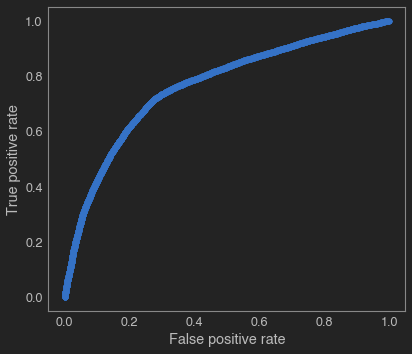

In [167]:
from jupyterthemes import jtplot

y_pred = me_valid.predict_proba(X_valid1).values

jtplot.style(theme='monokai')

fpr, tpr, thresholds = roc_curve(y_valid1, y_pred)
pit.plot(fpr, tpr, marker='o')
pit.xlabel("False positive rate")
pit.ylabel("True positive rate")
pit.grid()
pit.show()

In [168]:
me_valid.feature_importance(X_train1, 40)

,features,importance
644,逃げ率偏差,1109
11,compi,1055
586,調教師同コース同距離別騎乗回数偏差,1006
582,調教師距離別騎乗回数偏差,942
568,騎手同コース同距離別勝率偏差,927
22,furlong_5,924
567,騎手同コース同距離別騎乗回数偏差,917
675,騎乗騎手年間出遅れ率偏差,916
674,生涯出遅れ率偏差,911
575,調教師競馬場別勝率偏差,903


In [322]:
wr = me_valid.pred_table(X_valid1, 0.75, True)
bt = tansho_return_rate(X_valid1, wr)
fukusho_return_rate(bt[['race_id', 'h_num']])

点数：1501 レース数:9206 対象レース率:16.3% 単勝的中率:16.7% 的中数:250 賭金:150,100円 単勝配当合計:135,970円 単勝最高配当:2,720円 単勝回収率:90.6%
点数：1501 賭金:150,100円 複勝的中率:43.9% 複勝的中数:659 複勝配当合計:127,980円 複勝回収率:85.3%


In [171]:
me_test = ModelEvaluator(lgb_clf, haitou, std=True)
wrt = me_test.pred_table(X_test2, 0.75, True)
btt = tansho_return_rate(X_test2, wrt)
fukusho_return_rate(btt[['race_id', 'h_num']])

点数：758 レース数:3946 対象レース率:19.2% 単勝的中率:12.5% 的中数:95 賭金:75,800円 単勝配当合計:54,440円 単勝最高配当:2,480円 単勝回収率:71.8%
点数：758 賭金:75,800円 複勝的中率:38.4% 複勝的中数:291 複勝配当合計:58,940円 複勝回収率:77.8%


In [241]:
t = pd.read_csv('./csv_new2/base/training_prev.csv')
t.to_pickle('./pickle_new/training_prev.pickle')

In [479]:
df = pd.read_pickle('./pickle_new/training_prev.pickle')
df = df.reset_index()
df['date'] = df['date'].astype(str).map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df['id'] = df['horse_race_id']

df = df.sort_values(by='date', ascending = False)
t_allrace = df.set_index('race_id')
t_allrace['result'] = t_allrace['result'].map(lambda x: 1 if x < 2 else 0)

# t_allrace = t_allrace.drop([
#     'rank', 'rank.1', 'rank.2', 'rank.3', 'rank.4',
# #     'training_course', 'training_course.1', 'training_course.2', 'training_course.3', 'training_course.4'
# ], axis=1)
t_allrace = t_allrace.fillna({
    'rank': '-', 'rank.1': '-', 'rank.2': '-', 'rank.3': '-', 'rank.4': '-',
    'training_course': '', 'training_course.1': '', 'training_course.2': '', 'training_course.3': '', 'training_course.4': '',
})
t_categorical = process_categorical(t_allrace, [
    'rank', 'rank.1', 'rank.2', 'rank.3', 'rank.4',
    'training_course', 'training_course.1', 'training_course.2', 'training_course.3', 'training_course.4',
    'trainer_id'
])

t_train1, t_valid1 = split_data(t_categorical)
t_valid1, t_test2 = train_valid_split_data(t_valid1)

tdf = pd.read_csv('./training.csv')
tdf = tdf.reset_index()
tdf['date'] = tdf['date'].astype(str).map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
tdf['id'] = tdf['horse_race_id']

tdf = tdf.sort_values(by='date', ascending = False)
tt_allrace = tdf.set_index('race_id')
tt_allrace['result'] = tt_allrace['result'].map(lambda x: 1 if x < 2 else 0)

tt_allrace = tt_allrace.fillna({
    'rank': '-', 'rank.1': '-', 'rank.2': '-', 'rank.3': '-', 'rank.4': '-',
    'training_course': '', 'training_course.1': '', 'training_course.2': '', 'training_course.3': '', 'training_course.4': '',
})
t_test = process_categorical(tt_allrace, [
    'rank', 'rank.1', 'rank.2', 'rank.3', 'rank.4',
    'training_course', 'training_course.1', 'training_course.2', 'training_course.3', 'training_course.4',
])

X_training_train1 = t_train1.drop(['id', 'date', 'trainer_id', 'odds', 'index', 'result', 'time_odds', 'horse_race_id', 'horse_race_id.1', 'horse_race_id.2', 'horse_race_id.3', 'horse_race_id.4'], axis=1)
y_training_train1 = t_train1['result']
X_training_valid1 = t_valid1.drop(['date', 'trainer_id','index', 'horse_race_id','result', 'horse_race_id.1', 'horse_race_id.2', 'horse_race_id.3', 'horse_race_id.4'], axis=1)
y_training_valid1 = t_valid1['result']
X_training_test2 = t_test2.drop(['date','trainer_id', 'index', 'horse_race_id', 'result','horse_race_id.1', 'horse_race_id.2', 'horse_race_id.3', 'horse_race_id.4'], axis=1)
y_training_test2 = t_test2['result']
X_training_test1 = t_test.drop(['date', 'index', 'horse_race_id', 'result','horse_race_id.1', 'horse_race_id.2', 'horse_race_id.3', 'horse_race_id.4'], axis=1)
y_training_test1 = t_test['result']

In [376]:
optuna_params(X_training_train1, y_training_train1, X_training_valid1, y_training_valid1)

[I 2022-10-28 15:13:07,242] A new study created in memory with name: no-name-1e360c1a-6e3b-4209-ac74-7956a502344e
feature_fraction, val_score: inf:   0%|                                                                            | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.260010:  14%|#########                                                      | 1/7 [00:02<00:12,  2.16s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.249273	valid_1's binary_logloss: 0.26001
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.259733:  29%|##################                                             | 2/7 [00:04<00:10,  2.12s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250641	valid_1's binary_logloss: 0.259733
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.259733:  43%|###########################                                    | 3/7 [00:06<00:08,  2.13s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.25064	valid_1's binary_logloss: 0.259808
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.259733:  57%|####################################                           | 4/7 [00:08<00:06,  2.06s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250643	valid_1's binary_logloss: 0.259792
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.259733:  71%|#############################################                  | 5/7 [00:10<00:04,  2.07s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.25064	valid_1's binary_logloss: 0.259808
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.259733:  86%|######################################################         | 6/7 [00:12<00:02,  2.09s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.248871	valid_1's binary_logloss: 0.259986
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.259733: 100%|###############################################################| 7/7 [00:14<00:00,  2.10s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.249273	valid_1's binary_logloss: 0.26001


num_leaves, val_score: 0.259733:   0%|                                                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259733:   5%|###4                                                                | 1/20 [00:02<00:41,  2.18s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250199	valid_1's binary_logloss: 0.259865
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259733:  10%|######8                                                             | 2/20 [00:04<00:39,  2.18s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.25029	valid_1's binary_logloss: 0.259835
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259733:  15%|##########2                                                         | 3/20 [00:06<00:37,  2.19s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250086	valid_1's binary_logloss: 0.259869
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259733:  20%|#############6                                                      | 4/20 [00:08<00:35,  2.20s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.25009	valid_1's binary_logloss: 0.259869
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259731:  25%|#################                                                   | 5/20 [00:10<00:31,  2.08s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250954	valid_1's binary_logloss: 0.259731
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259731:  30%|####################4                                               | 6/20 [00:12<00:29,  2.13s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.249949	valid_1's binary_logloss: 0.259858
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259731:  35%|#######################7                                            | 7/20 [00:14<00:27,  2.11s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250489	valid_1's binary_logloss: 0.259799
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259731:  40%|###########################2                                        | 8/20 [00:16<00:24,  2.05s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250812	valid_1's binary_logloss: 0.259779
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259731:  45%|##############################6                                     | 9/20 [00:18<00:22,  2.02s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250812	valid_1's binary_logloss: 0.259779
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259731:  50%|#################################5                                 | 10/20 [00:21<00:20,  2.08s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.249967	valid_1's binary_logloss: 0.259858
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259731:  55%|####################################8                              | 11/20 [00:23<00:19,  2.15s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.249708	valid_1's binary_logloss: 0.259864
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259731:  60%|########################################1                          | 12/20 [00:25<00:16,  2.07s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250954	valid_1's binary_logloss: 0.259731
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259731:  65%|###########################################5                       | 13/20 [00:27<00:14,  2.08s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250484	valid_1's binary_logloss: 0.259799
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259731:  70%|##############################################9                    | 14/20 [00:29<00:12,  2.08s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250496	valid_1's binary_logloss: 0.259799
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259662:  75%|##################################################2                | 15/20 [00:31<00:10,  2.01s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251087	valid_1's binary_logloss: 0.259662
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259662:  80%|#####################################################6             | 16/20 [00:33<00:08,  2.05s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250334	valid_1's binary_logloss: 0.259837
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259662:  85%|########################################################9          | 17/20 [00:35<00:06,  2.06s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250607	valid_1's binary_logloss: 0.259733
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259662:  90%|############################################################3      | 18/20 [00:37<00:04,  2.14s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.249681	valid_1's binary_logloss: 0.259887
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259662:  95%|###############################################################6   | 19/20 [00:39<00:02,  2.11s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250607	valid_1's binary_logloss: 0.259733
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.259662: 100%|###################################################################| 20/20 [00:41<00:00,  2.10s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.250395	valid_1's binary_logloss: 0.259835


bagging, val_score: 0.259662:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.259662:  10%|#######1                                                               | 1/10 [00:01<00:17,  1.99s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251087	valid_1's binary_logloss: 0.259664
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.259661:  20%|##############2                                                        | 2/10 [00:03<00:15,  1.90s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.259661:  30%|#####################3                                                 | 3/10 [00:05<00:13,  1.95s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251088	valid_1's binary_logloss: 0.259664
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.259661:  40%|############################4                                          | 4/10 [00:07<00:11,  1.94s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251081	valid_1's binary_logloss: 0.259662
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.259661:  50%|###################################5                                   | 5/10 [00:09<00:09,  1.91s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251077	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.259661:  60%|##########################################6                            | 6/10 [00:11<00:07,  1.90s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251086	valid_1's binary_logloss: 0.259665
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.259661:  70%|#################################################6                     | 7/10 [00:13<00:05,  1.93s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251082	valid_1's binary_logloss: 0.259662
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.259661:  80%|########################################################8              | 8/10 [00:15<00:03,  1.92s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.25108	valid_1's binary_logloss: 0.259666
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.259661:  90%|###############################################################9       | 9/10 [00:17<00:01,  1.88s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251081	valid_1's binary_logloss: 0.259665
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.259661: 100%|######################################################################| 10/10 [00:19<00:00,  1.90s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.25108	valid_1's binary_logloss: 0.259664


feature_fraction_stage2, val_score: 0.259661:   0%|                                                                | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.259661:  17%|#########3                                              | 1/6 [00:01<00:09,  1.83s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.259661:  33%|##################6                                     | 2/6 [00:03<00:07,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259663
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.259661:  50%|############################                            | 3/6 [00:05<00:05,  1.91s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259667
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.259661:  67%|#####################################3                  | 4/6 [00:07<00:03,  1.89s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.259661:  83%|##############################################6         | 5/6 [00:09<00:01,  1.90s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259663
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.259661: 100%|########################################################| 6/6 [00:11<00:00,  1.89s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259667


regularization_factors, val_score: 0.259661:   0%|                                                                | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:   5%|##8                                                     | 1/20 [00:01<00:34,  1.83s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  10%|#####6                                                  | 2/20 [00:03<00:33,  1.85s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  15%|########4                                               | 3/20 [00:05<00:31,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251077	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  20%|###########2                                            | 4/20 [00:07<00:29,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  25%|##############                                          | 5/20 [00:09<00:27,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  30%|################8                                       | 6/20 [00:11<00:26,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  35%|###################5                                    | 7/20 [00:13<00:24,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251077	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  40%|######################4                                 | 8/20 [00:14<00:22,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  45%|#########################2                              | 9/20 [00:16<00:20,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  50%|###########################5                           | 10/20 [00:18<00:18,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  55%|##############################2                        | 11/20 [00:20<00:16,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  60%|#################################                      | 12/20 [00:22<00:15,  1.88s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251078	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259661:  65%|###################################7                   | 13/20 [00:24<00:13,  1.87s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259660:  70%|######################################5                | 14/20 [00:26<00:11,  1.87s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251078	valid_1's binary_logloss: 0.25966
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259660:  75%|#########################################2             | 15/20 [00:27<00:09,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259660:  80%|############################################           | 16/20 [00:29<00:07,  1.87s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251078	valid_1's binary_logloss: 0.25966
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259660:  85%|##############################################7        | 17/20 [00:31<00:05,  1.87s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259660:  90%|#################################################5     | 18/20 [00:33<00:03,  1.88s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251079	valid_1's binary_logloss: 0.25966
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259660:  95%|####################################################2  | 19/20 [00:35<00:01,  1.88s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.259660: 100%|#######################################################| 20/20 [00:37<00:00,  1.87s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251076	valid_1's binary_logloss: 0.259661


min_data_in_leaf, val_score: 0.259660:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.259660:  20%|############6                                                  | 1/5 [00:01<00:07,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251079	valid_1's binary_logloss: 0.25966
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.259660:  40%|#########################2                                     | 2/5 [00:03<00:05,  1.87s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251079	valid_1's binary_logloss: 0.25966
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.259660:  60%|#####################################8                         | 3/5 [00:05<00:03,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251079	valid_1's binary_logloss: 0.25966
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.259660:  80%|##################################################4            | 4/5 [00:07<00:01,  1.86s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251079	valid_1's binary_logloss: 0.25966
[LightGBM] [Info] Number of positive: 30730, number of negative: 413487
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 444217, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069178 -> initscore=-2.599387
[LightGBM] [Info] Start training from score -2.599387
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.259660: 100%|###############################################################| 5/5 [00:09<00:00,  1.88s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.251079	valid_1's binary_logloss: 0.25966


{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 9.763828704602075,
 'lambda_l2': 1.7070416028157427e-08,
 'num_leaves': 4,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.47628567079676276,
 'bagging_freq': 3,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [377]:
params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 9.763828704602075,
 'lambda_l2': 1.7070416028157427e-08,
 'num_leaves': 4,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.47628567079676276,
 'bagging_freq': 3,
 'min_child_samples': 20,
 'num_iterations': 1000,
}

t_lgb_clf = fit(params, X_training_train1, y_training_train1)

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.47628567079676276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47628567079676276
[LightGBM] [Warning] lambda_l2 is set=1.7070416028157427e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7070416028157427e-08
[LightGBM] [Warning] lambda_l1 is set=9.763828704602075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.763828704602075


In [378]:
t_me_valid = ModelEvaluator(t_lgb_clf, haitou, std=True)
t_me_valid.score(y_training_valid1, X_training_valid1)

0.6952842808034848

In [379]:
t_me_valid.feature_importance(X_training_train1, 40)

,features,importance
11,training_course,97
17,furlong_5.1,80
13,rank,80
2,furlong_5,69
47,furlong_5.3,63
26,training_course.1,63
9,furlong_3_2,63
0,h_num,62
4,furlong_3,62
23,furlong_4_3.1,59


In [380]:
twr = t_me_valid.pred_table(X_training_valid1, 0.7, True)
ttbt = tansho_return_rate(X_training_valid1, wr)

点数：1501 レース数:9203 対象レース率:16.3% 単勝的中率:16.7% 的中数:250 賭金:150,100円 単勝配当合計:135,970円 単勝最高配当:2,720円 単勝回収率:90.6%


In [398]:
X = X_training_valid1
kaime = pd.concat([
    bt[['race_id', 'h_num', 'win_ratio',  'time_odds', 'expected']],
    btt[['race_id', 'h_num',  'win_ratio', 'time_odds', 'expected']]]
).merge(haitou, on='race_id')

print("点数：{} レース数:{} 対象レース率:{:.1%} 単勝的中率:{:.1%} 的中数:{} 賭金:{:,}円 単勝配当合計:{:,}円 単勝最高配当:{:,}円 単勝回収率:{:.1%}". format(
    len(kaime),\
    len(X.groupby('race_id')),\
    len(kaime.groupby('race_id')) / len(X.groupby('race_id')),\
    len(kaime[kaime['h_num'] == kaime['1着馬番']]) / (len(kaime)),\
    len(kaime[kaime['h_num'] == kaime['1着馬番']]),\
    len(kaime) * 100,\
    kaime[kaime['h_num'] == kaime['1着馬番']]['単勝'].sum(),\
    kaime[kaime['h_num'] == kaime['1着馬番']]['単勝'].max(),\
    (kaime[kaime['h_num'] == kaime['1着馬番']]['単勝'].sum() / (len(kaime) * 100))
))


点数：2259 レース数:9203 対象レース率:24.5% 単勝的中率:15.3% 的中数:345 賭金:225,900円 単勝配当合計:190,410円 単勝最高配当:2,720円 単勝回収率:84.3%


In [381]:
t_me_test = ModelEvaluator(t_lgb_clf, haitou, std=True)
ttwr = t_me_test.pred_table(X_training_test2, 0.7, True)
tttbt = tansho_return_rate(X_training_test2, ttwr)

点数：1150 レース数:3944 対象レース率:27.6% 単勝的中率:6.3% 的中数:72 賭金:115,000円 単勝配当合計:129,080円 単勝最高配当:25,220円 単勝回収率:112.2%


In [34]:
fd = build_data('./pickle_new/base_race_20221016.pickle', './pickle_new/peds_vec.pickle', 4, vec)
X_fukusho_train1 = fd['X_train']
y_fukusho_train1 = fd['y_train']
X_fukusho_valid1 = fd['X_valid']
y_fukusho_valid1 = fd['y_valid']
X_fukusho_test2 = fd['X_test2']
y_fukusho_test2 = fd['y_test2']
X_fukusho_test1 = fd['X_test1']
y_fukusho_test1 = fd['y_test1']

In [459]:
optuna_params(X_fukusho_train1, y_fukusho_train1, X_fukusho_valid1, y_fukusho_valid1)

[I 2022-10-28 23:23:22,068] A new study created in memory with name: no-name-3abd7912-385e-4449-a1ec-09a023b2adeb
feature_fraction, val_score: inf:   0%|                                                                            | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.523823:  14%|#########                                                      | 1/7 [00:28<02:48, 28.07s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.500232	valid_1's binary_logloss: 0.523823
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.202149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.523823:  29%|##################                                             | 2/7 [00:52<02:08, 25.66s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.500251	valid_1's binary_logloss: 0.523823
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.651549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.511271:  43%|###########################                                    | 3/7 [01:20<01:46, 26.73s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493925	valid_1's binary_logloss: 0.511271
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.623941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.511271:  57%|####################################                           | 4/7 [01:51<01:25, 28.59s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493892	valid_1's binary_logloss: 0.511952
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.511271:  71%|#############################################                  | 5/7 [02:17<00:54, 27.46s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.490054	valid_1's binary_logloss: 0.51822
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.555067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.511271:  86%|######################################################         | 6/7 [02:43<00:27, 27.22s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493892	valid_1's binary_logloss: 0.511952
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.483473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.511271: 100%|###############################################################| 7/7 [03:10<00:00, 27.22s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493231	valid_1's binary_logloss: 0.527536


num_leaves, val_score: 0.511271:   0%|                                                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.446390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511271:   5%|###4                                                                | 1/20 [00:28<09:01, 28.52s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493125	valid_1's binary_logloss: 0.511506
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.447329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  10%|######8                                                             | 2/20 [00:57<08:38, 28.79s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.492925	valid_1's binary_logloss: 0.511222
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.538660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  15%|##########2                                                         | 3/20 [01:27<08:16, 29.21s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.492529	valid_1's binary_logloss: 0.511315
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.529110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  20%|#############6                                                      | 4/20 [01:55<07:39, 28.69s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493358	valid_1's binary_logloss: 0.511954
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.495992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  25%|#################                                                   | 5/20 [02:23<07:09, 28.61s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493114	valid_1's binary_logloss: 0.511559
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.547987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  30%|####################4                                               | 6/20 [02:53<06:46, 29.02s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493294	valid_1's binary_logloss: 0.511802
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.517489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  35%|#######################7                                            | 7/20 [03:21<06:12, 28.67s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493453	valid_1's binary_logloss: 0.511981
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.423055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  40%|###########################2                                        | 8/20 [03:49<05:43, 28.63s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493231	valid_1's binary_logloss: 0.511607
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.539831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  45%|##############################6                                     | 9/20 [04:17<05:11, 28.35s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493395	valid_1's binary_logloss: 0.511768
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.444823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  50%|#################################5                                 | 10/20 [04:47<04:48, 28.84s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.492579	valid_1's binary_logloss: 0.511315
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.517408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  55%|####################################8                              | 11/20 [05:11<04:06, 27.34s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.495084	valid_1's binary_logloss: 0.514008
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.513569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  60%|########################################1                          | 12/20 [05:41<03:45, 28.14s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.49255	valid_1's binary_logloss: 0.511315
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.516446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  65%|###########################################5                       | 13/20 [06:10<03:19, 28.49s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.492811	valid_1's binary_logloss: 0.511349
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.578385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  70%|##############################################9                    | 14/20 [06:40<02:52, 28.72s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.492821	valid_1's binary_logloss: 0.511349
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.496571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511222:  75%|##################################################2                | 15/20 [07:10<02:26, 29.28s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.492821	valid_1's binary_logloss: 0.511349
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.442225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511123:  80%|#####################################################6             | 16/20 [07:39<01:56, 29.20s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.492968	valid_1's binary_logloss: 0.511123
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.426152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511123:  85%|########################################################9          | 17/20 [08:08<01:27, 29.05s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.492984	valid_1's binary_logloss: 0.51147
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.505631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511123:  90%|############################################################3      | 18/20 [08:36<00:57, 28.77s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.492946	valid_1's binary_logloss: 0.511123
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.440918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511123:  95%|###############################################################6   | 19/20 [09:01<00:27, 27.74s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493863	valid_1's binary_logloss: 0.511724
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.425597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.511123: 100%|###################################################################| 20/20 [09:28<00:00, 28.42s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493568	valid_1's binary_logloss: 0.511972


bagging, val_score: 0.511123:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.458832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.511123:  10%|#######1                                                               | 1/10 [00:25<03:49, 25.50s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493125	valid_1's binary_logloss: 0.513071
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.452162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.511123:  20%|##############2                                                        | 2/10 [00:52<03:30, 26.35s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493021	valid_1's binary_logloss: 0.514367
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.434397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.511123:  30%|#####################3                                                 | 3/10 [01:21<03:12, 27.49s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.492991	valid_1's binary_logloss: 0.513336
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.476547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.511123:  40%|############################4                                          | 4/10 [01:54<02:58, 29.72s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493011	valid_1's binary_logloss: 0.514135
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.528587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.510809:  50%|###################################5                                   | 5/10 [02:21<02:23, 28.77s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.49312	valid_1's binary_logloss: 0.510809
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.528730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.510809:  60%|##########################################6                            | 6/10 [02:47<01:50, 27.70s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493116	valid_1's binary_logloss: 0.515823
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.579229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.510809:  70%|#################################################6                     | 7/10 [03:15<01:24, 28.06s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.492974	valid_1's binary_logloss: 0.51297
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.789547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.510809:  80%|########################################################8              | 8/10 [03:46<00:57, 28.79s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493076	valid_1's binary_logloss: 0.513263
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.640477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.510485:  90%|###############################################################9       | 9/10 [04:16<00:29, 29.36s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.481129	valid_1's binary_logloss: 0.510485
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.516656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.510485: 100%|######################################################################| 10/10 [04:45<00:00, 28.58s/it]


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.481096	valid_1's binary_logloss: 0.511028


feature_fraction_stage2, val_score: 0.510485:   0%|                                                                | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.652547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.510485:  17%|#########3                                              | 1/6 [00:31<02:39, 31.80s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493111	valid_1's binary_logloss: 0.511674
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.628590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.510485:  33%|##################6                                     | 2/6 [01:02<02:04, 31.24s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.481136	valid_1's binary_logloss: 0.51049
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.530157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.510485:  50%|############################                            | 3/6 [01:29<01:27, 29.26s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493104	valid_1's binary_logloss: 0.511955
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.368205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.510485:  67%|#####################################3                  | 4/6 [01:55<00:55, 27.93s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.481171	valid_1's binary_logloss: 0.511277
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.533359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.510485:  83%|##############################################6         | 5/6 [02:22<00:27, 27.53s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.493113	valid_1's binary_logloss: 0.513466
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.540368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.504555: 100%|########################################################| 6/6 [02:48<00:00, 28.11s/it]


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477972	valid_1's binary_logloss: 0.504555


regularization_factors, val_score: 0.504555:   0%|                                                                | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.484406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.504555:   5%|##8                                                     | 1/20 [00:26<08:22, 26.44s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478207	valid_1's binary_logloss: 0.506331
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.510093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.504554:  10%|#####6                                                  | 2/20 [00:53<08:02, 26.81s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477974	valid_1's binary_logloss: 0.504554
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.479980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.504554:  15%|########4                                               | 3/20 [01:20<07:40, 27.07s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477972	valid_1's binary_logloss: 0.504555
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.521336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503808:  20%|###########2                                            | 4/20 [01:48<07:13, 27.10s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478022	valid_1's binary_logloss: 0.503808
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.523467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503808:  25%|##############                                          | 5/20 [02:14<06:44, 26.96s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477972	valid_1's binary_logloss: 0.504555
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.495392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  30%|################8                                       | 6/20 [02:42<06:23, 27.36s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478075	valid_1's binary_logloss: 0.502209
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.463571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  35%|###################5                                    | 7/20 [03:12<06:06, 28.16s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477985	valid_1's binary_logloss: 0.50456
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.722084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  40%|######################4                                 | 8/20 [03:41<05:39, 28.30s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478005	valid_1's binary_logloss: 0.50453
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.673164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  45%|#########################2                              | 9/20 [04:10<05:14, 28.57s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477972	valid_1's binary_logloss: 0.504555
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.420020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  50%|###########################5                           | 10/20 [04:36<04:38, 27.88s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477995	valid_1's binary_logloss: 0.504239
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.724480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  55%|##############################2                        | 11/20 [05:04<04:11, 27.92s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477979	valid_1's binary_logloss: 0.503808
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.495756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  60%|#################################                      | 12/20 [05:31<03:40, 27.53s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477981	valid_1's binary_logloss: 0.503808
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.606438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  65%|###################################7                   | 13/20 [05:57<03:09, 27.06s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477975	valid_1's binary_logloss: 0.504554
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.504453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  70%|######################################5                | 14/20 [06:22<02:38, 26.39s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478618	valid_1's binary_logloss: 0.509058
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.641067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  75%|#########################################2             | 15/20 [06:49<02:12, 26.52s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477987	valid_1's binary_logloss: 0.504223
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.527919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  80%|############################################           | 16/20 [07:15<01:46, 26.52s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478167	valid_1's binary_logloss: 0.503269
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.564393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  85%|##############################################7        | 17/20 [07:42<01:19, 26.53s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478321	valid_1's binary_logloss: 0.505273
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.649881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  90%|#################################################5     | 18/20 [08:08<00:53, 26.58s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477974	valid_1's binary_logloss: 0.504554
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.629393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209:  95%|####################################################2  | 19/20 [08:35<00:26, 26.69s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478646	valid_1's binary_logloss: 0.508786
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.498081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502209: 100%|#######################################################| 20/20 [09:03<00:00, 27.17s/it]


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478027	valid_1's binary_logloss: 0.504975


min_data_in_leaf, val_score: 0.502209:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.500561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.502209:  20%|############6                                                  | 1/5 [00:27<01:47, 26.98s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478058	valid_1's binary_logloss: 0.502436
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.617053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.502209:  40%|#########################2                                     | 2/5 [00:53<01:20, 26.69s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478088	valid_1's binary_logloss: 0.503428
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.463251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.502209:  60%|#####################################8                         | 3/5 [01:20<00:53, 26.97s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478056	valid_1's binary_logloss: 0.502451
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.557050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.502196:  80%|##################################################4            | 4/5 [01:47<00:26, 26.84s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.478083	valid_1's binary_logloss: 0.502196
[LightGBM] [Info] Number of positive: 91640, number of negative: 346396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.449600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107323
[LightGBM] [Info] Number of data points in the train set: 438036, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209207 -> initscore=-1.329715
[LightGBM] [Info] Start training from score -1.329715
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.502196: 100%|###############################################################| 5/5 [02:13<00:00, 26.76s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.47811	valid_1's binary_logloss: 0.505232


{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 1.4367016376486885,
 'lambda_l2': 1.1166927044455953e-08,
 'num_leaves': 171,
 'feature_fraction': 0.716,
 'bagging_fraction': 0.4806708139231316,
 'bagging_freq': 2,
 'min_child_samples': 25,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [6]:
params = {
'objective': 'binary',
'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 1.4367016376486885,
 'lambda_l2': 1.1166927044455953e-08,
 'num_leaves': 171,
 'feature_fraction': 0.716,
 'bagging_fraction': 0.4806708139231316,
 'bagging_freq': 2,
 'min_child_samples': 25,
 'num_iterations': 1000,
}

f_lgb_clf = fit(params, X_fukusho_train1, y_fukusho_train1)

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [461]:
f_me_valid = ModelEvaluator(f_lgb_clf, haitou, std=True)
f_me_valid.score(y_fukusho_valid1, X_fukusho_valid1)

0.7689010129091167

In [462]:
fm = f_me_valid.pred_table(X_fukusho_valid1, 0.7)
fmr = bt[['race_id', 'place_id', 'h_num']].merge(fm, on='race_id')
fmr = fmr[fmr['h_num_x'] != fmr['h_num_y']]
uma_haito = umaren_return_rate(fmr, haitou)

点数：695 的中数:50 的中率:7.2%
馬連賭金:69,500円 馬連配当合計:67,960円 馬連最高配当:6,410円 馬連回収率:97.8%
馬単賭金:139,000円 馬単配当合計:143,010円 馬単最高配当:18,650円 馬単回収率:102.9%


In [469]:
f_me_test = ModelEvaluator(f_lgb_clf, haitou, std=True)
fmt = f_me_test.pred_table(X_fukusho_test2, 0.7)
fmrt = btt[['race_id', 'place_id', 'h_num']].merge(fmt, on='race_id')
fmrt = fmrt[fmrt['h_num_x'] != fmrt['h_num_y']]
t_uma_haito = umaren_return_rate(fmrt, haitou)

点数：379 的中数:28 的中率:7.4%
馬連賭金:37,900円 馬連配当合計:37,470円 馬連最高配当:3,430円 馬連回収率:98.9%
馬単賭金:75,800円 馬単配当合計:70,890円 馬単最高配当:5,480円 馬単回収率:93.5%


In [468]:
wide = pd.read_csv('./csv_new2/base/wide.csv')
w = uma_haito[['race_id', 'h_num_x', 'h_num_y']].merge(wide, on='race_id')

wide = 0
wide_tekichu = 0

for i in range(1, 8):
    sm = str(i)
    w_b3 = w[
        (
            ((w['h_num_x'] == w['wide' + sm + '_uma1']) | (w['h_num_x'] == w['wide' + sm + '_uma2']))
            &
            ((w['h_num_y'] == w['wide' + sm + '_uma1']) | (w['h_num_y'] == w['wide' + sm + '_uma2']))
        )
    ]
    wide = wide + w_b3['wide_' + sm].sum()
    wide_tekichu = wide_tekichu + len(w_b3)

print("ワイド点数：{} ワイド賭金:{:,}円 ワイド配当合計:{:,}円 ワイド的中数:{} ワイド的中率:{:.1%} ワイド回収率:{:.1%}". format(
    len(w),\
    len(w) * 100,\
    int(wide),\
    wide_tekichu,\
    wide_tekichu / len(w),\
    (wide / (len(w) * 100))
))

ワイド点数：695 ワイド賭金:69,500円 ワイド配当合計:64,410円 ワイド的中数:126 ワイド的中率:18.1% ワイド回収率:92.7%


In [471]:
fm3 = f_me_valid.pred_table(X_fukusho_valid1, 0.5)
uma3 = uma_haito.merge(fm3[['h_num']], on='race_id')
uma3 = uma3[
    (
        (uma3['h_num'] != uma3['h_num_y'])
        &
        (uma3['h_num'] != uma3['h_num_x'])
    )
]
sanrenkei(uma3[['race_id', 'h_num_x', 'h_num_y', 'h_num']], haitou)
wide_rate(uma3[['race_id', 'h_num_x', 'h_num_y', 'h_num']], haitou)


点数：678 的中数:18 的中率:2.7%
3連複賭金:67,800円 3連複配当合計:38,220円 3連複最高配当:10,140円 3連複回収率:56.4%
3連単賭金:406,800円 3連単配当合計:245,300円 3連単最高配当:68,720円 3連単回収率:60.3%
ワイド点数：1815 ワイド賭金:181,500円 ワイド配当合計:154,230円 ワイド的中数:240 ワイド的中率:13.2% ワイド回収率:85.0%


In [472]:
fmt3 = f_me_test.pred_table(X_fukusho_test2, 0.5)
t_uma3 = t_uma_haito.merge(fmt3[['h_num']], on='race_id')
t_uma3 = t_uma3[
    (
        (t_uma3['h_num'] != t_uma3['h_num_y'])
        &
        (t_uma3['h_num'] != t_uma3['h_num_x'])
    )
]
sanrenkei(t_uma3[['race_id', 'h_num_x', 'h_num_y', 'h_num']], haitou)
wide_rate(t_uma3[['race_id', 'h_num_x', 'h_num_y', 'h_num']], haitou)


点数：350 的中数:9 的中率:2.6%
3連複賭金:35,000円 3連複配当合計:24,440円 3連複最高配当:6,000円 3連複回収率:69.8%
3連単賭金:210,000円 3連単配当合計:147,890円 3連単最高配当:40,970円 3連単回収率:70.4%
ワイド点数：946 ワイド賭金:94,600円 ワイド配当合計:87,430円 ワイド的中数:125 ワイド的中率:13.2% ワイド回収率:92.4%


In [35]:
import math

weather = pd.read_csv('./csv_new2/20221127/weathers.csv')

me_test = ModelEvaluator(lgb_clf, haitou, std=True)
wrm = me_test.pred_table(X_test1, 0.75, False)
twt = wrm.reset_index().merge(weather, on='race_id')
twt['pred_rank'] = twt[['race_id', 'win_ratio']].groupby('race_id').rank(ascending=False)
twt = twt[
    (
        (twt['pred_rank'] == 1)
        |
        (twt['pred_rank'] == 2)
        |
        (twt['pred_rank'] == 3)
    )
]

twt['place'] = twt['place_id'].map(lambda x: places[x])
# twt['ratio'] = twt['win_ratio'].map(lambda x: math.floor(x * 100))
twt['num'] = twt['race_id'].astype(str).map(lambda x: x[14:])
lbets = twt.copy()

weather = pd.read_csv('./csv_new2/20221127/weathers.csv')
lbets = lbets.merge(weather, on='race_id')

lb = lbets[['race_id', 'place', 'num', 'h_num', 'pred_rank']].sort_values(by=['race_id', 'pred_rank'])

lb[['place', 'num', 'h_num']].to_csv('1127.csv')

In [36]:
f_me_test = ModelEvaluator(f_lgb_clf, haitou, True)

fm_test = f_me_test.pred_table(X_fukusho_test1, 0.5, True)
fm_test['pred_rank'] = fm_test[['win_ratio']].groupby(level=0).rank(ascending=False)
fm_test = fm_test.reset_index().merge(weather[['race_id', 'place_id']], on='race_id')

t_local_umaren = lbets[['race_id', 'h_num']].merge(fm_test, on='race_id')
t_local_umaren = t_local_umaren[t_local_umaren['h_num_x'] != t_local_umaren['h_num_y']]

l_umaren = lbets[['race_id', 'h_num']].merge(fm_test, on='race_id')

l_uma_haito = t_local_umaren[t_local_umaren['h_num_x'] != t_local_umaren['h_num_y']]

lu = l_uma_haito[['race_id', 'place_id', 'h_num_y', 'win_ratio', 'pred_rank']].drop_duplicates()
lu['place'] = lu['place_id'].map(lambda x: places[x])
lu['num'] = lu['race_id'].astype(str).map(lambda x: x[14:])

lub = lu[['race_id', 'place', 'num', 'h_num_y', 'pred_rank']].sort_values(by=['race_id', 'pred_rank'])
lub[['place', 'num', 'h_num_y']].to_csv('1127_ren.csv')